In [27]:
import sys
import os

# Define the full path to the 'utils' directory
utils_path = "/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils"
sys.path.append(utils_path)

from pathlib import Path
from PIL import Image
from byaldi import RAGMultiModalModel
from torch.utils.data import DataLoader
import PDFSerlalizer
import torch
import numpy as np
from typing import List
from tqdm import tqdm
from colpali_engine.models import ColPali, ColPaliProcessor
import base64
import io

# Paths
pdf_file = "/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/kostas_ignore/singapore-catalogue.pdf"
input_dir = "/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/cs_ai_2024_pdfs/"  # Directory containing PDFs
output_dir = "/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/"  # Directory to store extracted images
index_root = "./index_byaldi"  # Root directory for Byaldi index
index_name = "image_index"  # Name of the index
query_image_path = "/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/kostas_ignore/test.png"  # Path to query image

# Step 1: Extract images from the single PDF using DocumentHandler
os.makedirs(output_dir, exist_ok=True)
print(f"Processing {pdf_file}...")
doc = PDFSerlalizer.DocumentHandler()
doc.extract_images(
    pdf_file,
    output_dir,
    verbose=False,
    export_pages=False,      # Set True if you want full pages
    export_figures=True,     # Set True to extract figures
    export_tables=True       # Set True to extract tables
)

Processing /data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/kostas_ignore/singapore-catalogue.pdf...


In [28]:
model_name = "vidore/colpali-v1.2"
# Step 2: Initialize and index the extracted images with Byaldi
print("Initializing and indexing images with Byaldi...")
model = RAGMultiModalModel.from_pretrained(model_name, index_root=index_root)
colpali_model = model.model.model
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = ColPaliProcessor.from_pretrained(model_name)

# Prepare metadata (optional)
metadata = [{"filename": file_name} for file_name in os.listdir(output_dir)]

# Index the extracted images
model.index(
    input_path=Path(output_dir),
    index_name=index_name,
    store_collection_with_index=False,
    metadata=metadata,
    overwrite=True
)

Initializing and indexing images with Byaldi...
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


overwrite is on. Deleting existing index image_index to build a new one.
Indexing file: /data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-74.png
Added page 1 of document 0 to index.
Index exported to index_byaldi/image_index
Indexing file: /data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-99.png
Added page 1 of document 1 to index.
Index exported to index_byaldi/image_index
Indexing file: /data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-65.png
Added page 1 of document 2 to index.
Index exported to index_byaldi/image_index
Indexing file: /data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-8.png
Added page 1 of document 3 to index.
Index exported to index_byaldi/image_index
Indexing file: /data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-58.png
Added page 1 of document 4 t

{0: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-74.png',
 1: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-99.png',
 2: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-65.png',
 3: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-8.png',
 4: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-58.png',
 5: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-102.png',
 6: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-59.png',
 7: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-86.png',
 8: '/data/hdd1/users/kmparmp/DeepLearning_2024_2025_DSIT/utils/output/singapore-catalogue-picture-17.png',
 9: '/data/hdd1/users/kmparm

In [29]:
# Step 3: Perform Image-to-Image Retrieval
def get_batch_embeddings(images, model, processor, batch_size=2):
    """
    Generate embeddings for a batch of images.
    """
    dataloader = DataLoader(
        images,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda x: processor.process_images(x)
    )
    embeddings = []
    for batch in tqdm(dataloader, desc="Processing images"):
        with torch.no_grad():
            batch = {k: v.to(model.device) for k, v in batch.items()}
            batch_embeddings = model(**batch)
            if model.device == "cuda":
                batch_embeddings = batch_embeddings.float()
            embeddings.extend(list(torch.unbind(batch_embeddings.cpu())))
    return embeddings

In [30]:
extracted_images = [
    Image.open(os.path.join(output_dir, file)) for file in os.listdir(output_dir)
    if file.endswith(".png")
]

embeddings = get_batch_embeddings(extracted_images, colpali_model, processor, batch_size=2)

Processing images: 100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


In [31]:
# ImageRAG: Manages image storage and retrieval
class ImageRAG:
    def __init__(self, model, processor, device="cuda"):
        self.model = model
        self.processor = processor
        self.device = device
        self.embeddings = []
        self.image_base64s = []

    def _image_to_base64(self, image):
        buffer = io.BytesIO()
        image.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode()

    def _base64_to_image(self, base64_str):
        image_data = base64.b64decode(base64_str)
        return Image.open(io.BytesIO(image_data))

    def add_images_and_embeddings(self, images, embeddings):
        assert len(images) == len(embeddings)
        self.embeddings = embeddings
        for img in images:
            self.image_base64s.append(self._image_to_base64(img))

    def find_similar_images(self, query_image, top_k=5, batch_size=4):
        processed_query = self.processor.process_images([query_image])
        processed_query = {k: v.to(self.device) for k, v in processed_query.items()}
        with torch.no_grad():
            query_embedding = self.model(**processed_query)
            if self.device == "cuda":
                query_embedding = query_embedding.float()  # Ensure query_embedding is float32
            query_embedding = query_embedding.cpu()

        # Cast the query embedding to bfloat16 to match indexed embeddings' dtype
        query_embedding = query_embedding.to(torch.bfloat16)

        scores = []
        for i in range(0, len(self.embeddings), batch_size):
            batch_embeddings = self.embeddings[i:i + batch_size]
            batch_scores = []
            for emb in batch_embeddings:
                similarity = torch.matmul(query_embedding, emb.t())
                max_similarity = similarity.max(dim=-1)[0]
                score = max_similarity.sum()
                batch_scores.append(score)
            scores.extend(batch_scores)

        scores = torch.tensor(scores)
        top_k_values, top_k_indices = torch.topk(scores, min(top_k, len(scores)))

        results = []
        for similarity, idx in zip(top_k_values, top_k_indices):
            results.append({
                'similarity': similarity.item(),
                'image_base64': self.image_base64s[idx],
                'index': idx.item()
            })
        return results


In [32]:
rag = ImageRAG(colpali_model, processor, device=device)
rag.add_images_and_embeddings(extracted_images, embeddings)

query_image = Image.open(query_image_path)
results = rag.find_similar_images(query_image, top_k=5)


Displaying the input query image:


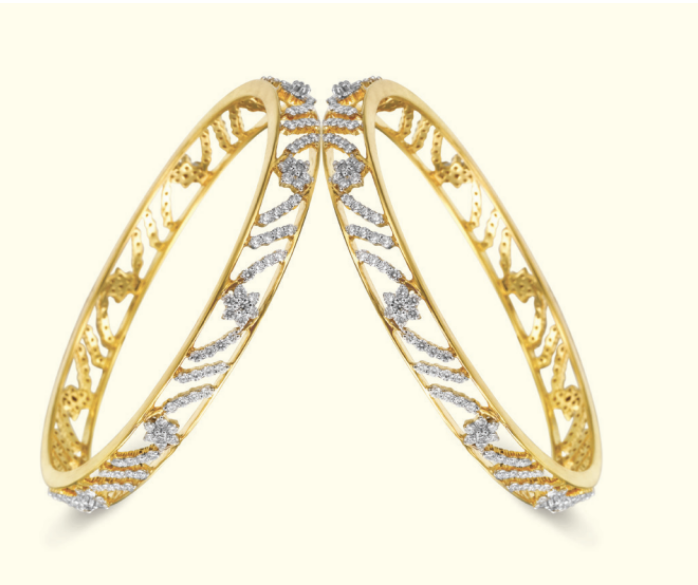

In [33]:
# Display the query image first
print("\nDisplaying the input query image:")
query_image = Image.open(query_image_path)
query_image.show(title="Query Image")


Match 1:
Similarity Score: 696.00


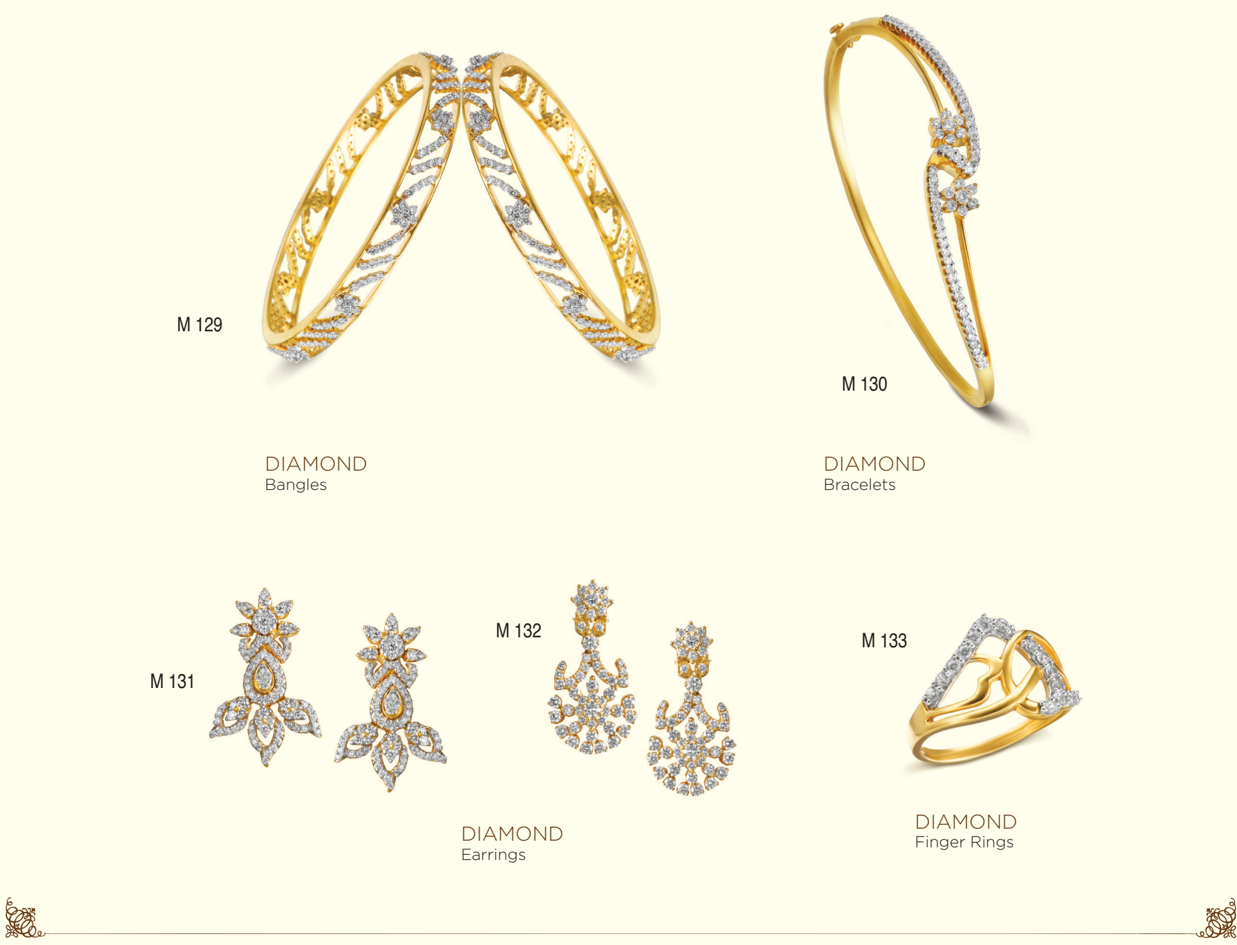


Match 2:
Similarity Score: 684.00


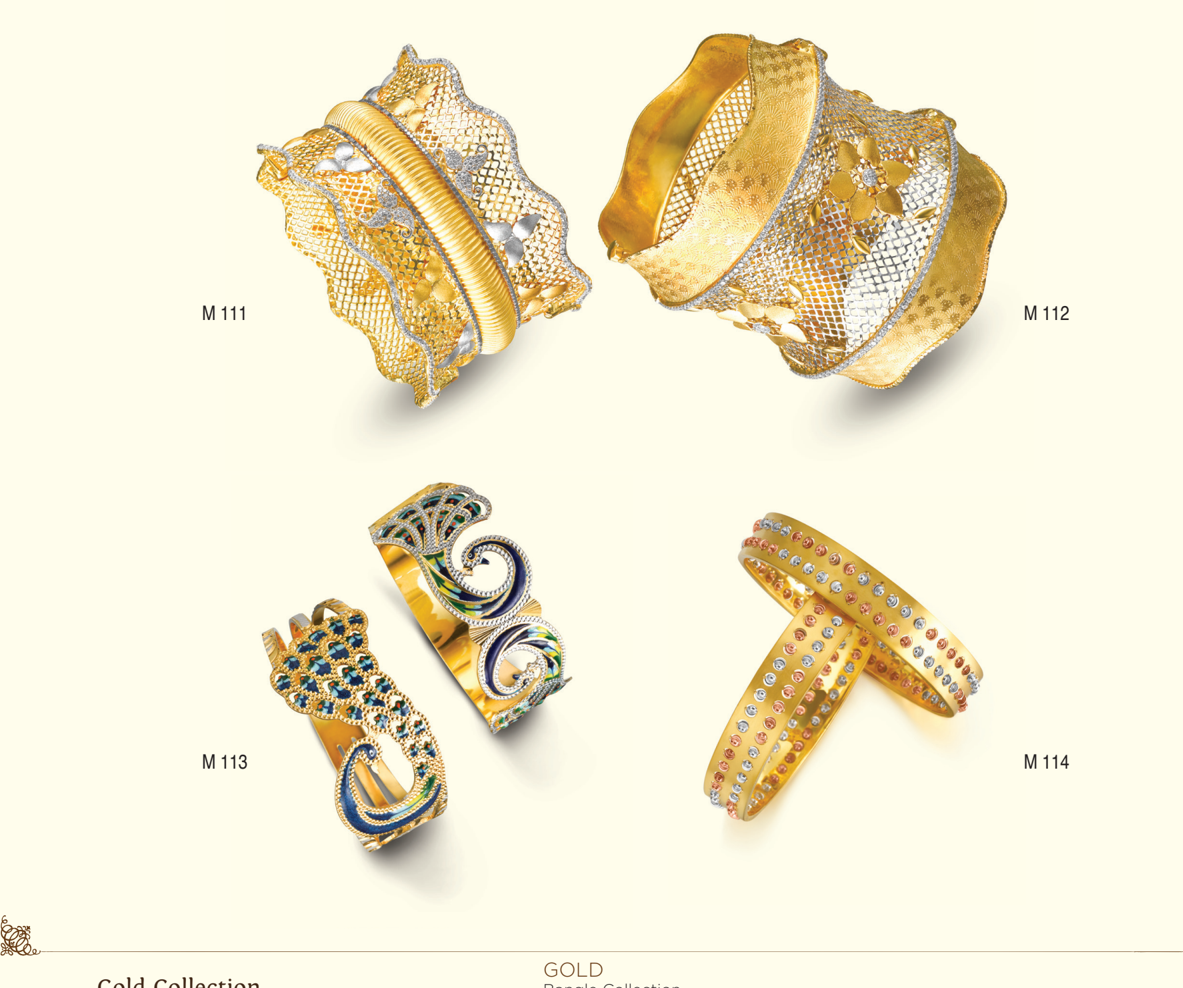


Match 3:
Similarity Score: 660.00


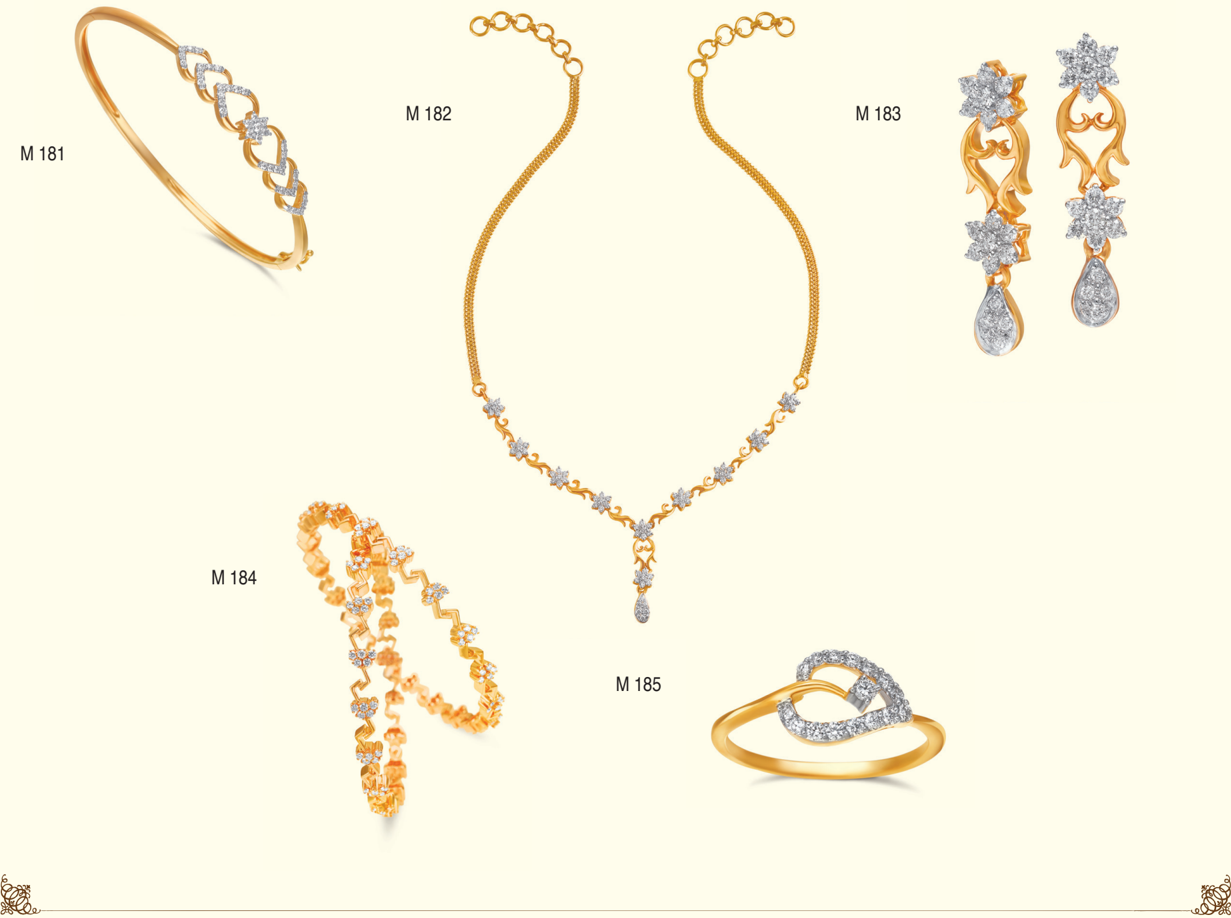


Match 4:
Similarity Score: 624.00


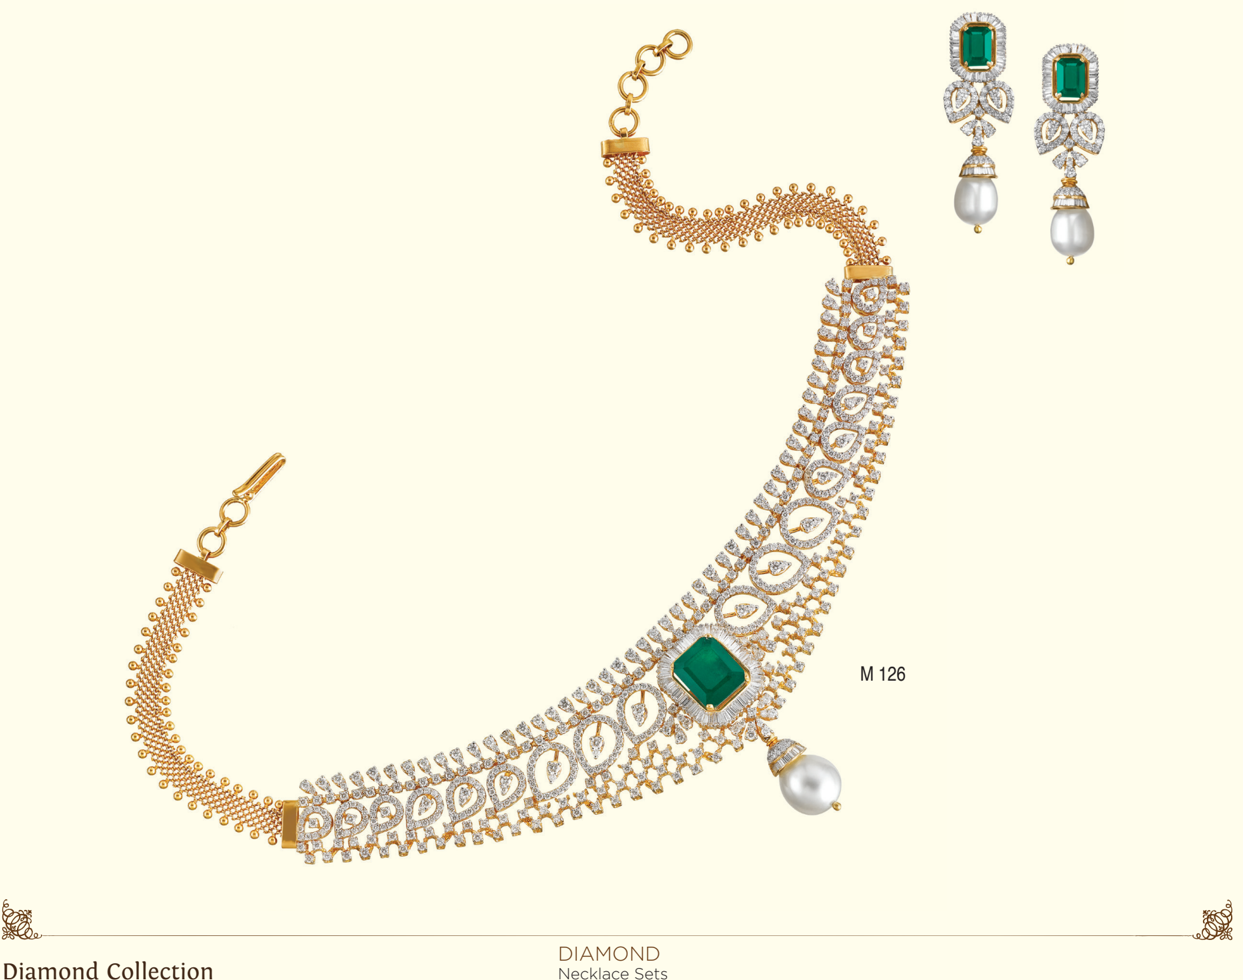


Match 5:
Similarity Score: 624.00


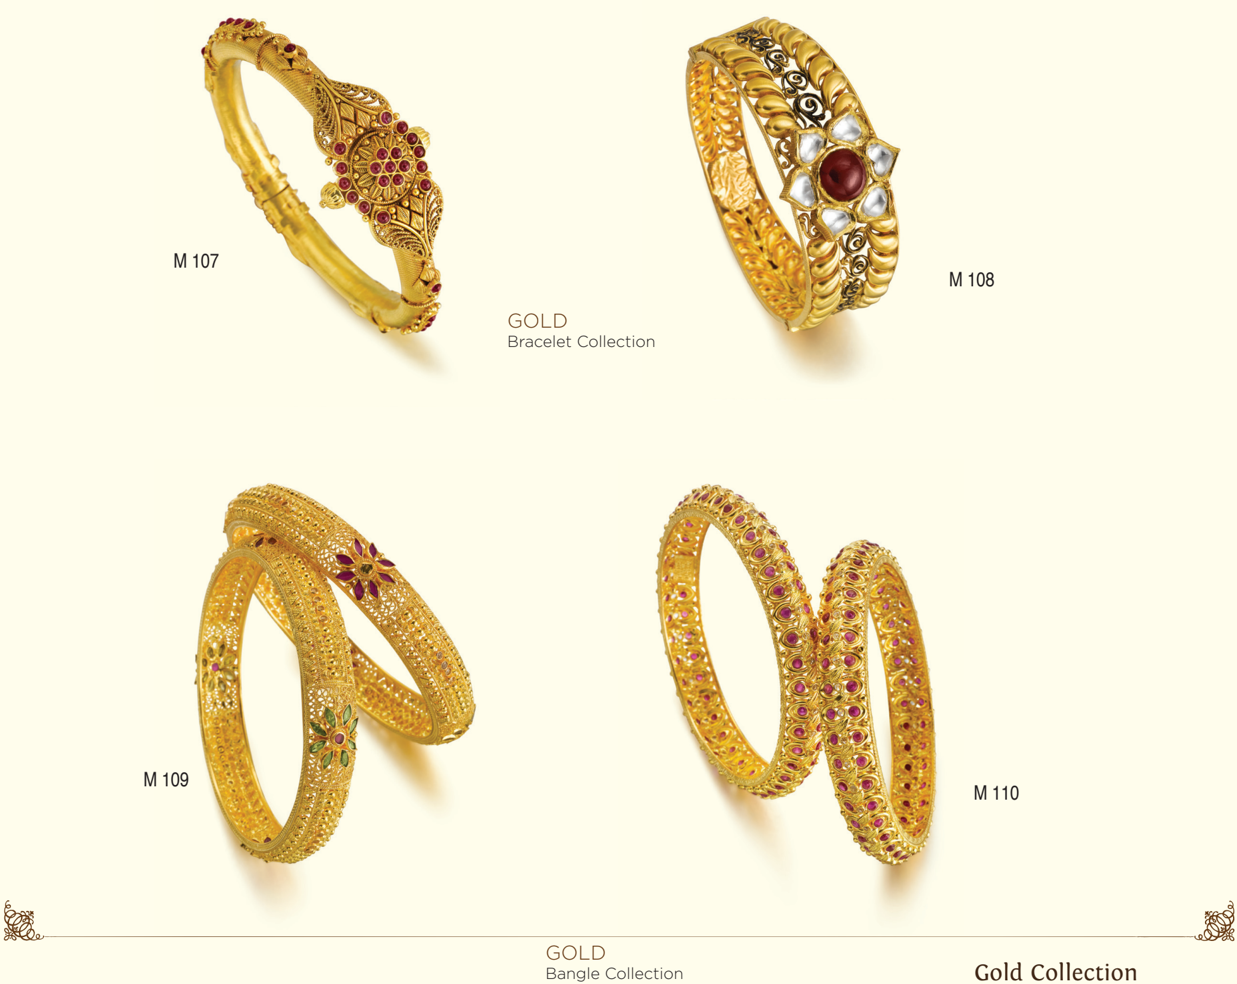

In [34]:
for i, result in enumerate(results):
    print(f"\nMatch {i+1}:")
    print(f"Similarity Score: {result['similarity']:.2f}")
    matched_image = rag._base64_to_image(result['image_base64'])
    matched_image.show()